- System 07 from the VADER dataset
- All available data (>3yrs)

In [1]:
from sys import path
path.append('..')
from clearsky.main import IterativeClearSky
from clearsky.utilities import make_time_series
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
PLOT_ARGS = {
    'linewidth': 1,
    'figsize': (12,8)
}
from datetime import datetime

In [2]:
from os.path import expanduser
home = expanduser("~")
with open(home+'/.aws/cassandra_cluster') as f:
    cluster_ip = f.readline().strip('\n')

In [3]:
cluster = Cluster([cluster_ip])
session = cluster.connect('measurements')

In [4]:
cql = """
    select site, meas_name, ts, sensor, meas_val_f 
    from measurement_raw
    where site in ('TADBC1078041')
        and meas_name = 'ac_power';
"""
rows = session.execute(cql)
df = pd.DataFrame(list(rows), )
df.replace(-999999.0, np.NaN, inplace=True)

In [5]:
df = make_time_series(df, return_keys=False).fillna(0)

In [6]:
df.head()

,ac_power_01
2015-04-24 15:10:00,0.3182
2015-04-24 15:15:00,0.3361
2015-04-24 15:20:00,0.3929
2015-04-24 15:25:00,0.3947
2015-04-24 15:30:00,0.4539


In [7]:
days = df.resample('D').max().index[1:-1]
start = days[0]
end = days[-1]
print(start, end)

2015-04-25 00:00:00 2018-10-20 00:00:00


In [8]:
end - start

Timedelta('1274 days 00:00:00')

Note data acquisition system errors (missing data) at the beginning of the data set. The algorithm is robust to errors like this, requiring no special filtering.

Text(0,0.5,'kW')

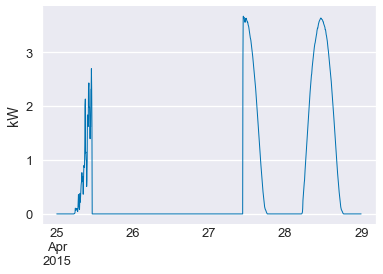

In [9]:
pa = PLOT_ARGS
pa['figsize'] = (6,4)
df.loc[start.strftime('%m/%d/%y'):(start + 3).strftime('%m/%d/%y')].plot(legend=False, **pa)
plt.ylabel('kW')

In [10]:
D = df.loc[start:end].iloc[:-1].values.reshape(288, -1, order='F')
p = df.loc[start:end]

In [11]:
U, Sig, Vt = np.linalg.svd(D, full_matrices=False)
U[:, 0] *= -1
Vt[0] *= -1

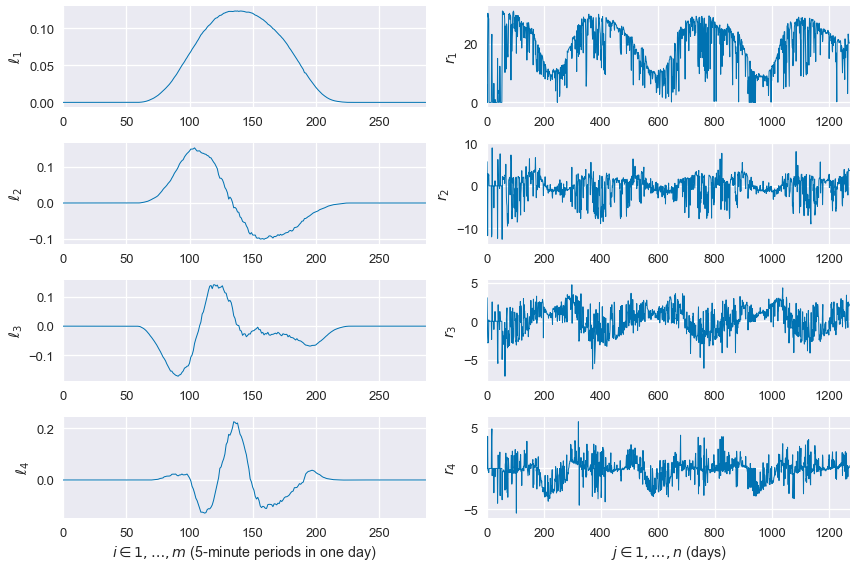

In [12]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,8))
for i in range(4):
    ax[i][0].plot(U.T[i], linewidth=1)
    ax[i][0].set_xlim(0, 287)
    ax[i][0].set_ylabel('$\\ell_{}$'.format(i+1))
    ax[i][1].plot((np.diag(Sig).dot(Vt))[i], linewidth=1)
    ax[i][1].set_xlim(0, D.shape[1])
    ax[i][1].set_ylabel('$r_{}$'.format(i+1))
ax[-1][0].set_xlabel('$i \\in 1, \\ldots, m$ (5-minute periods in one day)')
ax[-1][1].set_xlabel('$j \\in 1, \\ldots, n$ (days)')
plt.tight_layout()
plt.show()

In [13]:
ics = IterativeClearSky(D, k=6)

In [14]:
ics.mu_L = 5e2
ics.mu_R = 1e3
ics.tau = 0.9
ics.minimize_objective(max_iter=10)

starting at 527070.159 [2128.5172709024087, 185.8958349219077, 388031.60026465036, 136724.14519558876]
iteration 1: 2081.347 [1856.987   20.008  204.352    0.   ]
iteration 2: 1783.605 [1576.326   17.955  189.324    0.   ]
iteration 3: 1761.666 [1551.064   22.424  188.178    0.   ]
iteration 4: 1756.205 [1544.652   24.03   187.524    0.   ]
iteration 5: 1752.946 [1541.088   25.292  186.566    0.   ]
iteration 6: 1750.607 [1539.399   25.981  185.227    0.   ]
iteration 7: 1748.561 [1538.101   26.592  183.868    0.   ]
iteration 8: 1746.779 [1537.288   27.154  182.337    0.   ]
iteration 9: 1745.184 [1536.503   27.689  180.992    0.   ]
Minimization complete in 5.44 minutes


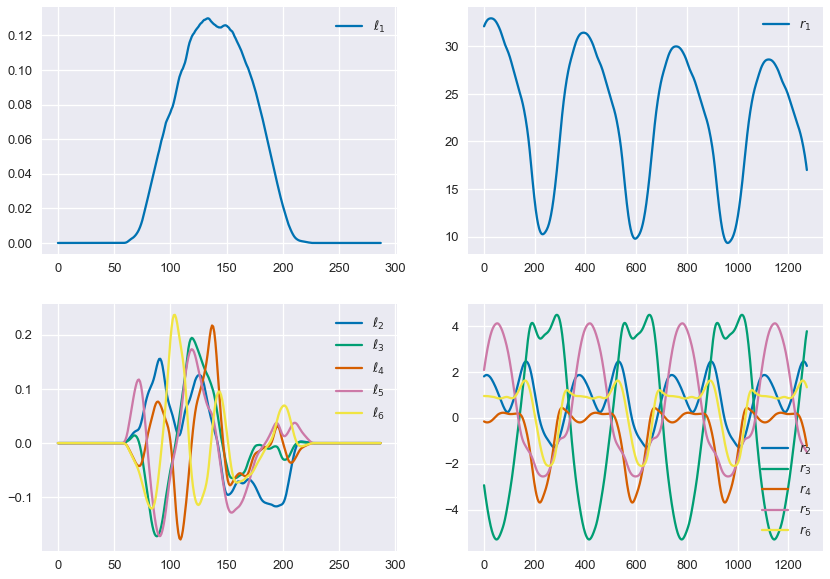

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
ax[0, 1].plot(ics.R_cs.value[0])
ax[1, 1].plot(ics.R_cs.value[1:].T)
ax[0, 0].plot(ics.L_cs.value[:, 0])
ax[1, 0].plot(ics.L_cs.value[:, 1:])
ax[0, 0].legend(['$\\ell_1$'])
ax[1, 0].legend(['$\\ell_{}$'.format(ix) for ix in range(2, ics.R_cs.value.shape[0]+1)])
ax[0, 1].legend(['$r_{1}$'])
ax[1, 1].legend(['$r_{}$'.format(ix) for ix in range(2, ics.R_cs.value.shape[0]+1)])
plt.show()

Here is the estimated degradation rate (year on year energy-yield) for the system:

In [16]:
ics.beta.value

array(-0.04582829)

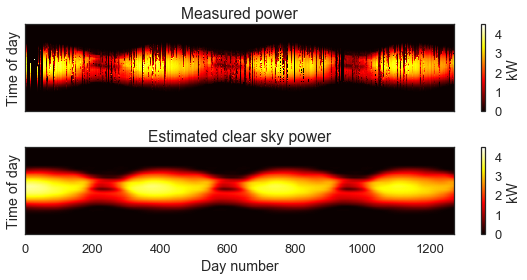

In [17]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=2, figsize=(8,4), sharex=True)
    foo = ax[0].imshow(ics.D, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(ics.L_cs.value.dot(ics.R_cs.value), cmap='hot',
                       vmin=0, vmax=np.max(ics.D), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power')
    plt.colorbar(foo, ax=ax[0], label='kW', ticks=range(5))
    plt.colorbar(bar, ax=ax[1], label='kW', ticks=range(5))
    ax[1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    plt.tight_layout()

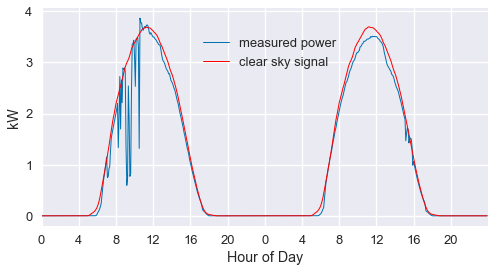

In [18]:
D1 = 340
D2 = D1 + 2
actual = p[D1*288:D2*288].values
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F')
fig, ax = plt.subplots(nrows=1, figsize=(8,4))
ax.plot(actual, linewidth=1, label='measured power')
ax.plot(clearsky, linewidth=1, color='red', label='clear sky signal')
plt.legend(loc=(.35,.7))
ax.set_xlim(0, 288*(D2-D1))
ax.set_ylabel('kW')
ax.set_xticks(np.arange(0, 288*2, 2*24))
ax.set_xticklabels(np.tile(np.arange(0,24,4),2))
ax.set_xlabel('Hour of Day')
plt.show()

In [19]:
print(sum(ics.L_cs.shape) + sum(ics.R_cs.shape))

1574


(0, 1440)

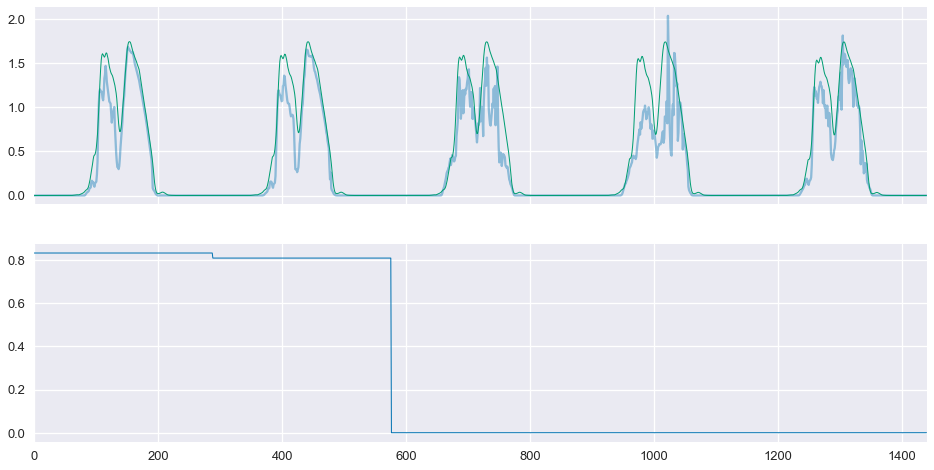

In [20]:
D1 = 220
D2 = D1+5
actual = p[D1*288:D2*288].values
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F')
fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[1].plot(np.repeat(ics.weights[D1:D2], 288), linewidth=1)
ax[1].set_xlim(0, 288*(D2-D1))

In [21]:
ics.beta.value

array(-0.04582829)

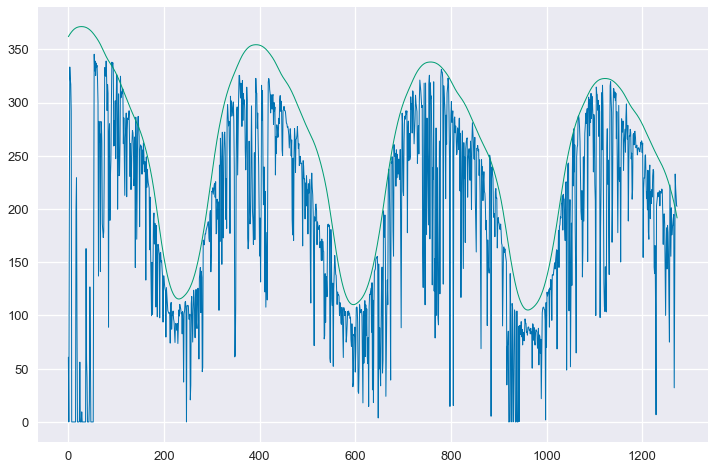

In [22]:
plt.figure(figsize=(12,8))
plt.plot(np.sum(D, axis=0), linewidth=1)
plt.plot(ics.R_cs.value[0] * np.sum(ics.L_cs.value[:, 0]), linewidth=1)

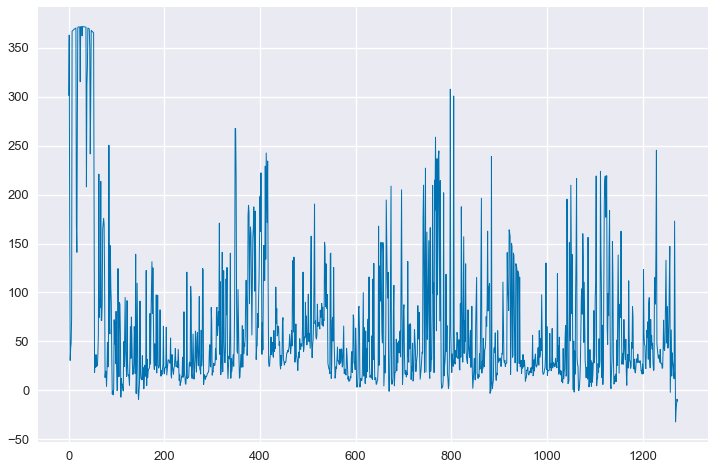

In [28]:
residuals1 = ics.R_cs.value[0] * np.sum(ics.L_cs.value[:, 0]) - np.sum(D, axis=0)
plt.figure(figsize=(12,8))
plt.plot(residuals1, linewidth=1)

In [24]:
ics2 = IterativeClearSky(D, k=6)
ics2.mu_L = 5e2
ics2.mu_R = 1e3
ics2.tau = 0.9
ics2.minimize_objective(max_iter=10, calc_deg=False)

starting at 527070.159 [2128.5172709024087, 185.8958349219077, 388031.60026465036, 136724.14519558876]
iteration 1: 2420.209 [2194.348   20.008  205.853    0.   ]
iteration 2: 2098.625 [1887.707   19.648  191.27     0.   ]
iteration 3: 2078.486 [1864.093   23.971  190.421    0.   ]
iteration 4: 2072.476 [1857.981   25.426  189.069    0.   ]
iteration 5: 2069.225 [1855.258   26.318  187.649    0.   ]
iteration 6: 2066.792 [1853.505   27.009  186.278    0.   ]
iteration 7: 2064.873 [1852.183   27.4    185.29     0.   ]
Minimization complete in 4.36 minutes


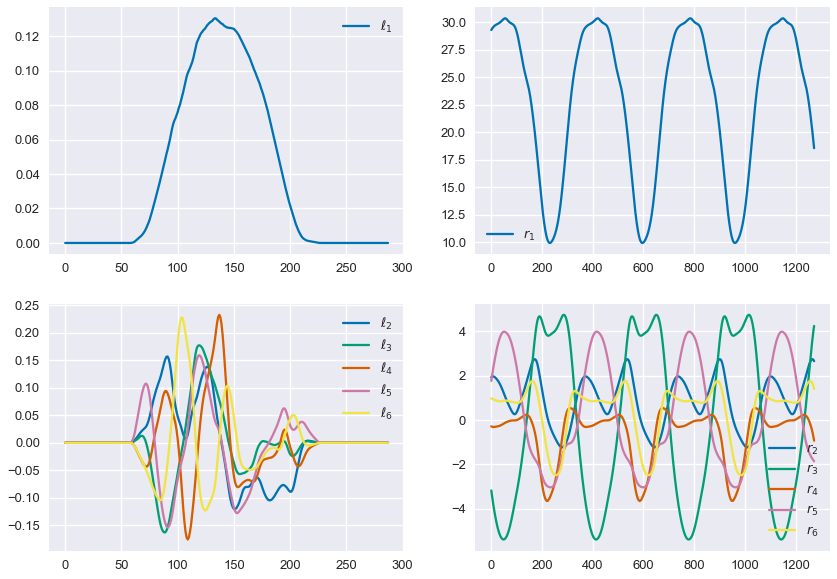

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
ax[0, 1].plot(ics2.R_cs.value[0])
ax[1, 1].plot(ics2.R_cs.value[1:].T)
ax[0, 0].plot(ics2.L_cs.value[:, 0])
ax[1, 0].plot(ics2.L_cs.value[:, 1:])
ax[0, 0].legend(['$\\ell_1$'])
ax[1, 0].legend(['$\\ell_{}$'.format(ix) for ix in range(2, ics2.R_cs.value.shape[0]+1)])
ax[0, 1].legend(['$r_{1}$'])
ax[1, 1].legend(['$r_{}$'.format(ix) for ix in range(2, ics2.R_cs.value.shape[0]+1)])
plt.show()

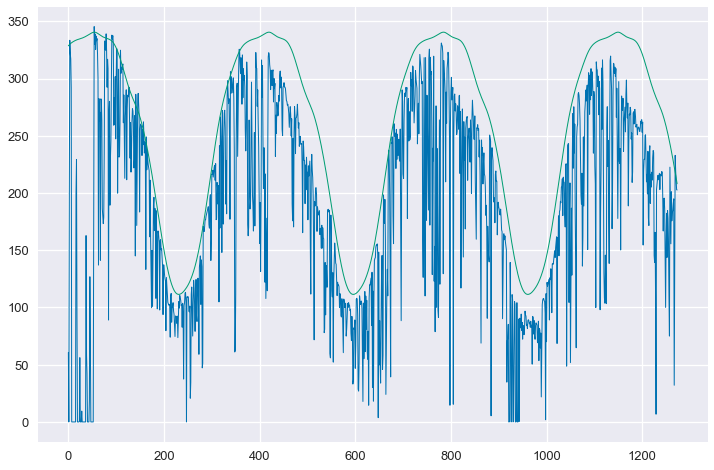

In [26]:
plt.figure(figsize=(12,8))
plt.plot(np.sum(D, axis=0), linewidth=1)
plt.plot(ics2.R_cs.value[0] * np.sum(ics2.L_cs.value[:, 0]), linewidth=1)

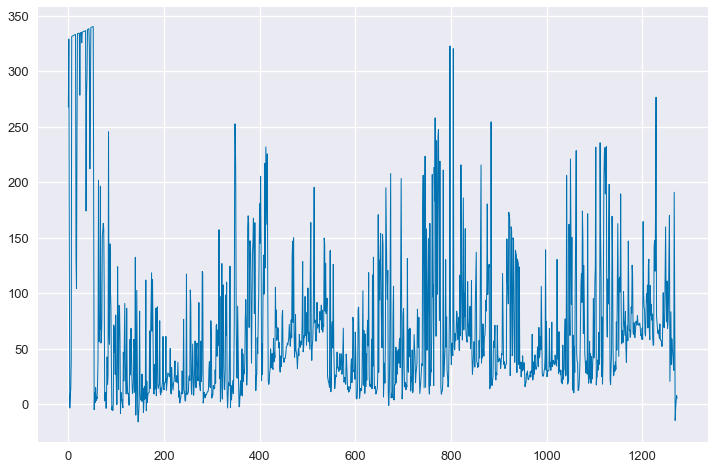

In [29]:
residuals2 = ics2.R_cs.value[0] * np.sum(ics2.L_cs.value[:, 0]) - np.sum(D, axis=0)
plt.figure(figsize=(12,8))
plt.plot(residuals2, linewidth=1)

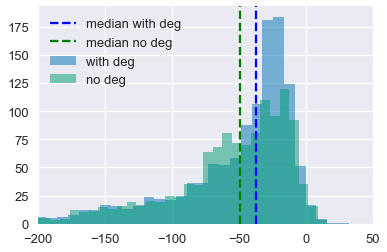

In [67]:
plt.hist(-residuals1, bins=50, alpha=0.5, label='with deg')
plt.hist(-residuals2, bins=50, alpha=0.5, label='no deg')
plt.axvline(np.median(-residuals1), color='b', label='median with deg', ls='--')
plt.axvline(np.median(-residuals2), color='g', label='median no deg', ls='--')
plt.xlim(-200, 50)
plt.legend()
plt.show()

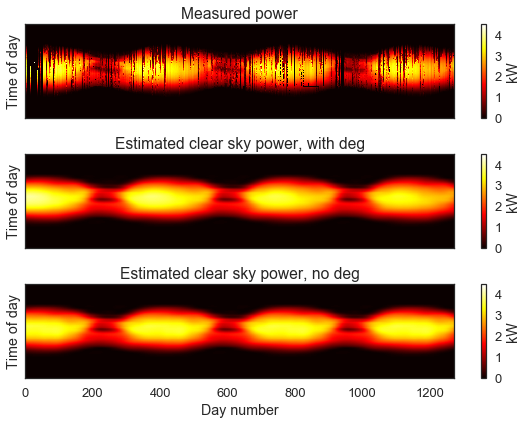

In [53]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=3, figsize=(8,6), sharex=True)
    foo = ax[0].imshow(ics.D, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(ics.L_cs.value.dot(ics.R_cs.value), cmap='hot',
                       vmin=0, vmax=np.max(ics.D), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power, with deg')
    fbr = ax[2].imshow(ics2.L_cs.value.dot(ics2.R_cs.value), cmap='hot',
                       vmin=0, vmax=np.max(ics.D), interpolation='none', aspect='auto')
    ax[2].set_title('Estimated clear sky power, no deg')
    plt.colorbar(foo, ax=ax[0], label='kW', ticks=range(5))
    plt.colorbar(bar, ax=ax[1], label='kW', ticks=range(5))
    plt.colorbar(fbr, ax=ax[2], label='kW', ticks=range(5))
    ax[-1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    ax[2].set_yticks([])
    ax[2].set_ylabel('Time of day')
    plt.tight_layout()

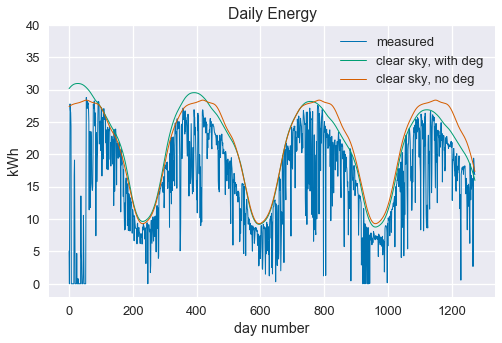

In [52]:
plt.figure(figsize=(8,5))
plt.plot(np.sum(D, axis=0) * 5/60, linewidth=1, label='measured')
plt.plot(ics.R_cs.value[0] * np.sum(ics.L_cs.value[:, 0]) * 5/60, linewidth=1, label='clear sky, with deg')
plt.plot(ics2.R_cs.value[0] * np.sum(ics2.L_cs.value[:, 0]) * 5/60, linewidth=1, label='clear sky, no deg')
plt.ylim(-2, 40)
plt.legend(loc=1)
plt.title('Daily Energy')
plt.xlabel('day number')
plt.ylabel('kWh')
plt.show()

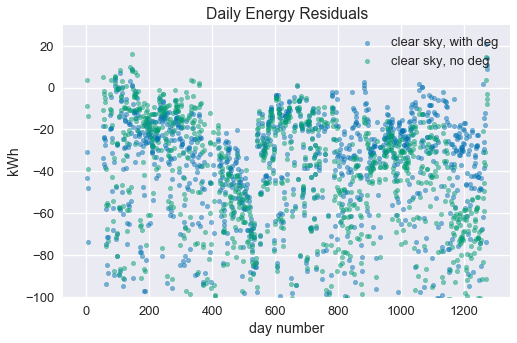

In [72]:
plt.figure(figsize=(8,5))
plt.scatter(range(len(residuals1)), -residuals1, marker='.', alpha=0.5, label='clear sky, with deg')
plt.scatter(range(len(residuals2)), -residuals2, marker='.', alpha=0.5, label='clear sky, no deg')
plt.ylim(-100, 30)
plt.legend(loc=1)
plt.title('Daily Energy Residuals')
plt.xlabel('day number')
plt.ylabel('kWh')
plt.show()